<a href="https://colab.research.google.com/github/element-fi/elf-simulations/blob/dp_mart_agents/examples/notebooks/fred_louie_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hyperdrive [NAME] simulation
We use the following setup:
- TBD
* variable rate:
    * step function
    * rate changes every 3 months
    * 

For details on the simulation framework, please see our <a href="https://elfpy.element.fi/">simulation documentation</a>

### Install repo requirements & import packages

In [1]:
# test: skip-cell
try: # install dependencies only if running on google colab
    import google.colab # check if running in colab
    !pip install -r https://raw.githubusercontent.com/element-fi/elf-simulations/main/requirements-3.8.txt 
    !pip install git+https://github.com/element-fi/elf-simulations.git
except:
    print("running locally & trusting that you have the dependencies installed")

running locally & trusting that you have the dependencies installed


In [2]:
from __future__ import annotations

import numpy as np
from numpy.random._generator import Generator
import matplotlib.pyplot as plt

from elfpy import WEI
from elfpy.types import MarketActionType, MarketAction, Quantity, TokenType, MarketDeltas
from elfpy.simulators import Simulator
from elfpy.agent import Agent
from elfpy.markets import Market
from elfpy.utils import sim_utils
import elfpy.utils.outputs as output_utils
import elfpy.utils.post_processing as post_processing
from elfpy.types import MarketState, StretchedTime, Config
from elfpy.utils.outputs import get_gridspec_subplots

### Setup experiment parameters

In [3]:
config = Config()

# General config parameters
config.title = "Hyperdrive smart agent demo"
config.pricing_model_name = "Hyperdrive" # can be yieldspace or hyperdrive

config.num_trading_days = 90#1095 # Number of simulated trading days
config.num_blocks_per_day = 5#7200 # Blocks in a given day (7200 means ~12 sec per block)
config.num_position_days = 10#90 # How long a token reaches maturity

config.trade_fee_percent = 0.05 # fee percent collected on trades
config.redemption_fee_percent = 0.05 # fee collected on the spread of the flat portion

config.target_pool_apr = 0.01 # target pool APR of the initial market after the LP
config.target_liquidity = 500_000_000 # target total liquidity of the initial market, before any trades

config.log_level = output_utils.text_to_log_level("INFO") # Logging level, should be in ["DEBUG", "INFO", "WARNING"]
config.log_filename = "./frida_n_louie.log" # Output filename for logging

config.shuffle_users = False

# Notebook specific parameters
num_fridas = 50
num_louies = 3 * num_fridas
num_agents = num_fridas + num_louies # int specifying how many agents you want to simulate
trade_chance = 0.1 # 1 / (config.num_trading_days * num_agents) # on a given block, an agent will trade with probability `trade_chance`

budget_min = 5_000
budget_max = 250_000
budget_mean = 75_000
budget_std = 50_000

frida_risk_min = 0.0
frida_risk_max = 0.06
frida_risk_mean = 0.02
frida_risk_std = 0.01

### Setup agents

In [4]:
class FixedFrida(Agent):
    """
    Agent that paints & opens fixed rate borrow positions
    """

    def __init__(self, rng: Generator, trade_chance: float, risk_threshold: float, wallet_address: int, budget: int = 10_000) -> None:
        """Add custom stuff then call basic policy init"""
        self.trade_chance = trade_chance
        self.risk_threshold = risk_threshold
        self.rng = rng
        super().__init__(wallet_address, budget)

    def action(self, market: Market) -> list[MarketAction]:
        """Implement a Fixed Frida user strategy

        I'm an actor with a high risk threshold
        I'm willing to open up a fixed-rate borrow (aka a short) if the fixed rate is ~2% higher than the variable rate
            approx means gauss mean=0.02; std=0.005, clipped at 0, 5
        I will never close my short until the simulation stops
            UNLESS my short reaches the token duration mark (e.g. 6mo)
            realistically, people might leave them hanging
        I have total budget of 2k -> 250k (gauss mean=75k; std=50k, i.e. 68% values are within 75k +/- 50k)
        I only open one short at a time

        Parameters
        ----------
        market : Market
            the trading market

        Returns
        -------
        action_list : list[MarketAction]
        """
        # Any trading at all is based on a weighted coin flip -- they have a trade_chance% chance of executing a trade
        gonna_trade = self.rng.choice([True, False], p=[self.trade_chance, 1-self.trade_chance])
        if not gonna_trade:
            return []
        
        action_list = []
        for short_time in self.wallet.shorts: # loop over shorts
            if market.time - short_time >= market.position_duration.days: # if any short is mature
                trade_amount = self.wallet.shorts[short_time] # close the whole thing
                action_list += [
                    self.create_agent_action(action_type=MarketActionType.CLOSE_SHORT, trade_amount=trade_amount, mint_time=short_time)
                ]

        short_balances = [short.balance for short in self.wallet.shorts.values()]
        has_opened_short = bool(any(short_balance > 0 for short_balance in short_balances))
        if (market.rate - market.market_state.vault_apr) > self.risk_threshold and not has_opened_short: # approx 2% higher
            trade_amount = self.get_max_short(market) # maximum amount the agent can short given the market and the agent's wallet
            if trade_amount > WEI:
                action_list += [
                    self.create_agent_action(action_type=MarketActionType.OPEN_SHORT, trade_amount=trade_amount, mint_time=market.time)
                ]

        return action_list

In [5]:
class LongLouie(Agent):
    """
    Long-nosed agent that opens longs
    """

    def __init__(self, rng: Generator, trade_chance: float, risk_threshold: float, wallet_address: int, budget: int = 10_000) -> None:
        """Add custom stuff then call basic policy init"""
        self.trade_chance = trade_chance
        self.risk_threshold = risk_threshold
        self.rng = rng
        super().__init__(wallet_address, budget)

    def action(self, market: Market) -> list[MarketAction]:
        """Implement a Long Louie user strategy

        I'm not willing to open a long if it will cause the fixed-rate apr to go below the variable rate
            I simulate the outcome of my trade, and only execute on this condition
        I only close if the position has matured
        I have total budget of 2k -> 250k (gauss mean=75k; std=50k, i.e. 68% values are within 75k +/- 50k)
        I only open one long at a time

        Parameters
        ----------
        market : Market
            the trading market

        Returns
        -------
        action_list : list[MarketAction]
        """
        # Any trading at all is based on a weighted coin flip -- they have a trade_chance% chance of executing a trade
        gonna_trade = self.rng.choice([True, False], p=[self.trade_chance, 1-self.trade_chance])
        if not gonna_trade:
            return []
        
        action_list = []
        for long_time in self.wallet.longs: # loop over longs
            if market.time - long_time >= market.position_duration.days: # if any long is mature
                trade_amount = self.wallet.longs[long_time] # close the whole thing
                action_list += [
                    self.create_agent_action(action_type=MarketActionType.CLOSE_LONG, trade_amount=trade_amount, mint_time=long_time)
                ]

        long_balances = [long.balance for long in self.wallet.longs.values()]
        has_opened_long = bool(any(long_balance > 0 for long_balance in long_balances))
        if (market.rate - market.market_state.vault_apr) > self.risk_threshold and not has_opened_long: # risk_threshold = 0
            # FIXME: get_max_long_given_rate(rate) returns max long such that the market_state.fixed_rate == rate
            trade_amount = self.get_max_long(market) # maximum amount the agent can long given the market and the agent's wallet
            if trade_amount > WEI:
                # simulate the trade
                trade_result = market.pricing_model.calc_out_given_in(
                    in_=Quantity(amount=trade_amount, unit=TokenType.BASE),
                    market_state=market.market_state,
                    time_remaining=market.position_duration,
                )
                # apply the trade to a fake market state
                market_state_post_trade = market.market_state.copy()
                market_deltas = MarketDeltas(
                    d_base_asset=trade_result.market_result.d_base,
                    d_token_asset=trade_result.market_result.d_bonds,
                    d_base_buffer=trade_result.breakdown.with_fee,
                )
                market_state_post_trade.apply_delta(market_deltas)
                # get the new fixed rate from the fake market state
                new_fixed_rate = market.pricing_model.calc_apr_from_reserves(market_state_post_trade, market.position_duration)
                if new_fixed_rate > market.market_state.vault_apr:
                    action_list += [
                        self.create_agent_action(action_type=MarketActionType.OPEN_LONG, trade_amount=trade_amount, mint_time=market.time)
                    ]

        return action_list

In [6]:

class LPAgent(Agent):
    """Adds a large LP"""
    def action(self, market: Market):
        """implement user strategy"""
        if self.wallet.lp_tokens > 0: # has already opened the lp
            action_list = []
        else:
            action_list = [
                self.create_agent_action(
                    action_type=MarketActionType.ADD_LIQUIDITY, trade_amount=self.budget
                ),
            ]
        return action_list

In [7]:

def get_example_agents(rng: Generator, num_fridas: int, num_louies: int, existing_agents: int = 0) -> list[Agent]:
    """Instantiate a set of custom agents"""
    agents = []
    for address in range(existing_agents, existing_agents + num_fridas):
        risk_threshold = np.maximum(frida_risk_min, np.minimum(frida_risk_max, rng.normal(loc=frida_risk_mean, scale=frida_risk_std)))
        budget = np.maximum(budget_min, np.minimum(250_000, rng.normal(loc=budget_mean, scale=budget_std)))
        agent = FixedFrida(
            rng=rng,
            trade_chance=trade_chance,
            risk_threshold=risk_threshold,
            wallet_address=address,
            budget=budget,
        )
        agent.log_status_report()
        agents += [agent]
    existing_agents += len(agents)
    for address in range(existing_agents, existing_agents + num_louies):
        risk_threshold = 0.0
        budget = np.maximum(budget_min, np.minimum(250_000, rng.normal(loc=budget_mean, scale=budget_std)))
        agent = LongLouie(
            rng=rng,
            trade_chance=trade_chance,
            risk_threshold=risk_threshold,
            wallet_address=address,
            budget=budget,
        )
        agent.log_status_report()
        agents += [agent]
    return agents


### Define vault apr process

In [8]:
# Define the vault apr
vault_apr = np.array([0.01]*config.num_trading_days)
vault_apr[30:] = 0.05
config.vault_apr = vault_apr.tolist()
config.freeze()

### Setup simulation objects

In [9]:
# define root logging parameters
output_utils.setup_logging(log_filename=config.log_filename, log_level=config.log_level)

# instantiate the pricing model
pricing_model = sim_utils.get_pricing_model(config.pricing_model_name)

# instantiate the market
position_duration = StretchedTime(
    days=config.num_position_days,
    time_stretch=pricing_model.calc_time_stretch(config.target_pool_apr),
    normalizing_constant=config.num_position_days,
)

init_target_liquidity = 1 # tiny amount for setting up apr
share_reserves_direct, bond_reserves_direct = pricing_model.calc_liquidity(
    market_state=MarketState(
        share_price=config.init_share_price,
        init_share_price=config.init_share_price
    ),
    target_liquidity=init_target_liquidity,
    target_apr=config.target_pool_apr * config.num_position_days / 365,
    position_duration=position_duration,
)
market = Market(
    pricing_model=pricing_model,
    market_state=MarketState(
        share_reserves=share_reserves_direct,
        bond_reserves=bond_reserves_direct,
        base_buffer=0,
        bond_buffer=0,
        lp_reserves=init_target_liquidity / config.init_share_price,
        init_share_price=config.init_share_price,  # u from YieldSpace w/ Yield Baring Vaults
        share_price=config.init_share_price,  # c from YieldSpace w/ Yield Baring Vaults
        vault_apr=config.vault_apr[0],  # yield bearing source apr
        trade_fee_percent=config.trade_fee_percent,  # g
        redemption_fee_percent=config.redemption_fee_percent,
    ),
    position_duration=position_duration
)

# Instantiate the initial LP agent.
current_market_liquidity = market.pricing_model.calc_total_liquidity_from_reserves_and_price(
    market_state=market.market_state, share_price=market.market_state.share_price
)
lp_amount = config.target_liquidity - current_market_liquidity
init_agents = [LPAgent(wallet_address=0, budget=lp_amount)]

# initialize the simulator using only the initial LP.
simulator = Simulator(config=config, market=market)
simulator.add_agents(init_agents)
simulator.collect_and_execute_trades()

### Run the simulation

In [10]:
# add the random agents
trading_agents = get_example_agents(rng=simulator.rng, num_fridas=num_fridas, num_louies=num_louies, existing_agents=len(simulator.agents))
simulator.add_agents(trading_agents)
print(f"Simulator has {len(simulator.agents)} agents")

# run the simulation
simulator.run_simulation()

Simulator has 201 agents


In [14]:
# convert simulation state to a pandas dataframe
trades = post_processing.compute_derived_variables(simulator)
for col in trades:
    if col.startswith("agent") and not "type" in col:
        divisor = 1e6 # 1 million divisor for everyone
        trades[col] = trades[col] / divisor

### Plot simulation results


### vault & pool apr

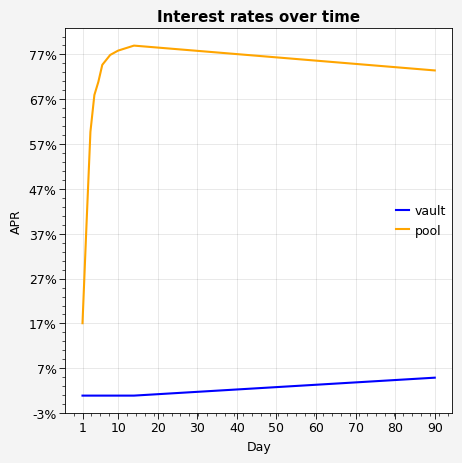

In [57]:
trades_agg = trades.groupby("day").agg(
    {
        "vault_apr": ["mean"],
        "pool_apr": ["mean"],
    }
)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()

fig, axes, _ = get_gridspec_subplots()
ax = axes[0]
ax = trades_agg.iloc[0:].plot(x="day", y="vault_apr_mean", ax=ax, label="vault", c="blue")
ax = trades_agg.iloc[0:].plot(x="day", y="pool_apr_mean", ax=ax, label="pool", c="orange")
ax.set_title("Interest rates over time")
ax.set_xlabel("Day")
ax.set_ylabel("APR")
ax.legend()

xtick_step = 10
ax.set_xticks([0]+[x for x in range(9, simulator.config.num_trading_days + 1, xtick_step)])
ax.set_xticklabels(['1']+[str(x+1) for x in range(9, simulator.config.num_trading_days + 1, xtick_step)])

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1])
ax.set_yticks([i for i in np.arange(ylim[0], ylim[1], 0.1)])
ax.set_yticklabels([f"{(i):.0%}" for i in ax.get_yticks()])

fig.set_size_inches((5, 5))

analysis goes here

Text(0.5, 1.0, 'Market reserves')

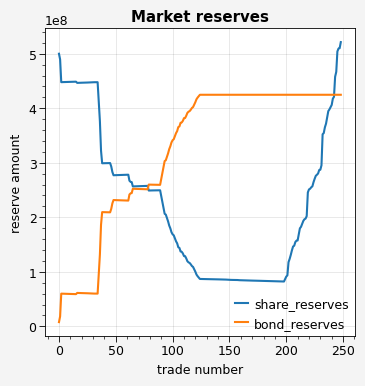

In [16]:
fig, axes, _ = output_utils.get_gridspec_subplots(nrows=1, ncols=1)
ax = trades.iloc[:-1].plot(x="run_trade_number", y="share_reserves", ax=axes[0], c="blue")
ax = trades.iloc[:-1].plot(x="run_trade_number", y="bond_reserves", ax=axes[0], c="orange")
ax.set_xlabel("trade number")
ax.set_ylabel("reserve amount")
ax.set_title("Market reserves")
fig.set_size_inches((5, 5))

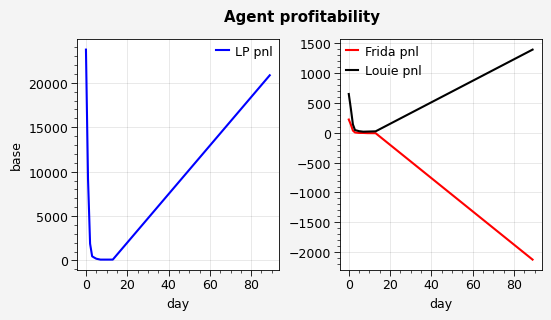

In [53]:
lp_trades = trades.groupby("day").agg(
    {
        f"agent_{0}_pnl": ["sum"]
    }
)
lp_trades.columns = ["_".join(col).strip() for col in lp_trades.columns.values]
lp_trades = lp_trades.reset_index()

fridas = [agent_id for agent_id in range(len(simulator.agents)) if simulator.agents[agent_id].__class__.__name__ == "FixedFrida"]
frida_trades = trades.groupby("day").agg(
    {
        f"agent_{agent_id}_pnl": ["sum"]
        for agent_id in fridas
    }
)
frida_trades.columns = ["_".join(col).strip() for col in frida_trades.columns.values]
frida_trades = frida_trades.reset_index()

louies = [agent_id for agent_id in range(len(simulator.agents)) if simulator.agents[agent_id].__class__.__name__ == "LongLouie"]
louies_trades = trades.groupby("day").agg(
    {
        f"agent_{agent_id}_pnl": ["sum"]
        for agent_id in louies
    }
)
louies_trades.columns = ["_".join(col).strip() for col in louies_trades.columns.values]
louies_trades = louies_trades.reset_index()

fig, axes, _ = output_utils.get_gridspec_subplots(nrows=1, ncols=2, wspace=0.3)

ax = axes[0]
ax.plot(trades_agg["day"], lp_trades.sum(axis=1), label="LP pnl", c="blue")
ax.set_ylabel("base")

ax = axes[1]
ax.plot(trades_agg["day"], frida_trades.sum(axis=1), label="Frida pnl", c="orange")
ax.plot(trades_agg["day"], louies_trades.sum(axis=1), label="Louie pnl", c="black")

for ax in axes:
    ax.set_xlabel("day")
    ax.legend()
text_handle = fig.suptitle("Agent profitability")
fig.set_size_inches((10, 5))

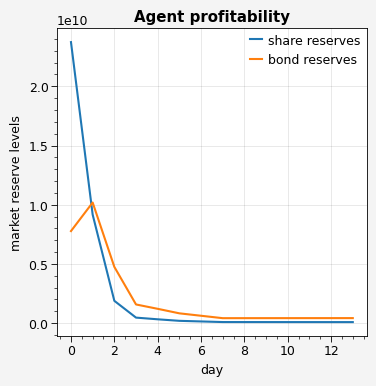

In [18]:
trades_agg = trades.groupby("day").agg(
    {
        "share_reserves": ["sum"],
        "bond_reserves": ["sum"]
    }
)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
fix, axes, _ = output_utils.get_gridspec_subplots(nrows=1, ncols=1)
ax = trades_agg.iloc[:-1].plot(x="day", y="share_reserves_sum", ax=axes[0], label="share reserves", c="blue")
ax = trades_agg.iloc[:-1].plot(x="day", y="bond_reserves_sum", ax=axes[0], label="bond reserves", c="orange")
ax.set_xlabel("day")
ax.set_ylabel("market reserve levels")
text_handle = ax.set_title("Agent profitability")
fig.set_size_inches((5, 5))

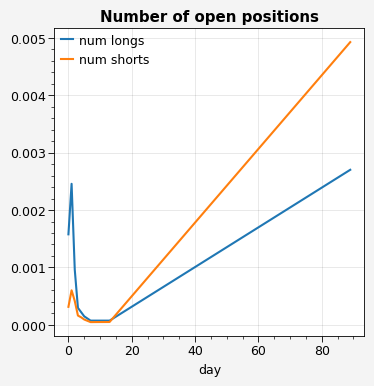

In [19]:
num_longs_and_shorts = {
    f"agent_{agent_id}_num_longs": ["sum"]
    for agent_id in range(len(simulator.agents))
}
num_longs_and_shorts.update({
    f"agent_{agent_id}_num_shorts": ["sum"]
    for agent_id in range(len(simulator.agents))
})
trades_agg = trades.groupby("day").agg(num_longs_and_shorts)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
longs = trades_agg.filter(regex="num_longs").sum(axis=1)
shorts = trades_agg.filter(regex="num_shorts").sum(axis=1)
fix, axes, _ = output_utils.get_gridspec_subplots(nrows=1, ncols=1)
ax = axes[0]
ax.plot(trades_agg["day"], longs, label="num longs", c="blue")
ax.plot(trades_agg["day"], shorts, label="num shorts", c="orange")
ax.legend()
ax.set_xlabel("day")
text_handle = ax.set_title("Number of open positions")
fig.set_size_inches((5, 5))

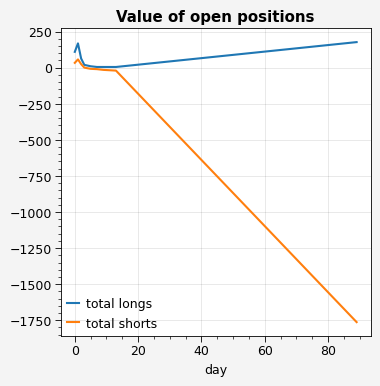

In [20]:
total_longs_and_shorts = {
    f"agent_{agent_id}_total_longs": ["sum"]
    for agent_id in range(len(simulator.agents))
}
total_longs_and_shorts.update({
    f"agent_{agent_id}_total_shorts": ["sum"]
    for agent_id in range(len(simulator.agents))
})
trades_agg = trades.groupby("day").agg(total_longs_and_shorts)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
longs = trades_agg.filter(regex="total_longs").sum(axis=1)
shorts = trades_agg.filter(regex="total_shorts").sum(axis=1)
fix, axes, _ = output_utils.get_gridspec_subplots(nrows=1, ncols=1)
ax = axes[0]
ax.plot(trades_agg["day"], longs, label="total longs", c="blue")
ax.plot(trades_agg["day"], shorts, label="total shorts", c="orange")
ax.legend()
ax.set_xlabel("day")
text_handle = ax.set_title("Value of open positions")
fig.set_size_inches((5, 5))

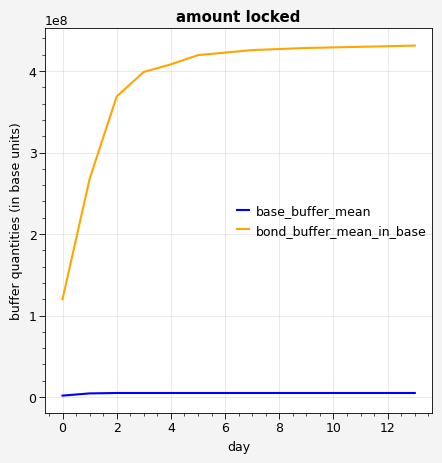

In [58]:
trades_agg = trades.groupby("day").agg(
    {
        "base_buffer": ["mean"],
        "bond_buffer": ["mean"],
        "spot_price": ["mean"],
    }
)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
trades_agg["bond_buffer_mean_in_base"] = trades_agg["bond_buffer_mean"] / trades_agg["spot_price_mean"]

fig, axes, _ = output_utils.get_gridspec_subplots()
ax = trades_agg.iloc[:-1].plot(x="day", y="base_buffer_mean", ax=axes[0], c="blue")
ax = trades_agg.iloc[:-1].plot(x="day", y="bond_buffer_mean_in_base", ax=axes[0], c="orange")
text_handle = ax.set_title("amount locked")
ax.set_xlabel("day")
ax.set_ylabel("buffer quantities (in base units)")
fig.set_size_inches((5, 5))

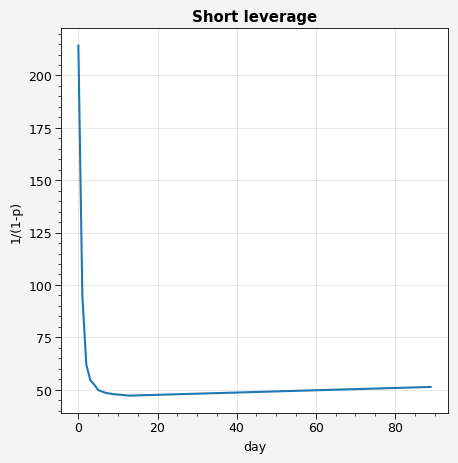

In [59]:
trades_agg = trades.groupby("day").agg(
    {
        "spot_price": ["mean"]
    }
)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
trades_agg["leverage"] = 1 / (1 - trades_agg["spot_price_mean"])

fig, axes, _ = output_utils.get_gridspec_subplots()
ax = axes[0]
ax.plot(trades_agg["day"], trades_agg["leverage"])
text_handle = ax.set_title("Short leverage")
ax.set_xlabel("day")
ax.set_ylabel("1/(1-p)")
fig.set_size_inches((5, 5))